## Zebrafish data alignment and visualization

### Imports

In [1]:
# Needed packages
import numpy as np
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import ndimage
from skimage import io
# import cv2
from skimage.color import rgb2gray
# import plotly.graph_objects as go
# import plotly.io as pio
import pickle
from scipy.ndimage import zoom
from scipy.interpolate import RegularGridInterpolator
# from numba import njit
from multiprocessing import Pool
import copy
# import itk
import logging
# from umap import UMAP
# from sklearn.cluster import KMeans
# import plotly.express as px
import subprocess
# from naparimovie import Movie
import pandas as pd

from scipy.ndimage import median_filter, binary_dilation, binary_closing, binary_erosion,binary_fill_holes, gaussian_filter
import mcubes


from scipy.ndimage import shift
from scipy.ndimage.interpolation import rotate
import matplotlib.pyplot as plt

# For working display in vscode
# pio.renderers.default = "notebook_connected"


/var/folders/2g/tv_2q6vs7wv37p_f_48x5rsr0000gp/T/ipykernel_12707/208265071.py:32: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


# retrieve contour

In [2]:
# load the 4cluster images
import os
PATH_IMAGES = np.array([os.path.join('../../alignment_zebrafish/data/anatomical_clusters_global/', x) for x in os.listdir('../../alignment_zebrafish/data/anatomical_clusters_global/')])


In [3]:
ix_sort = np.argsort([float(x.split('/')[-1].split('.')[0]) for x in PATH_IMAGES])
PATH_IMAGES = PATH_IMAGES[ix_sort]

In [4]:
images = [np.load(x) for x in PATH_IMAGES]

In [9]:
images[1].shape

(150, 482)

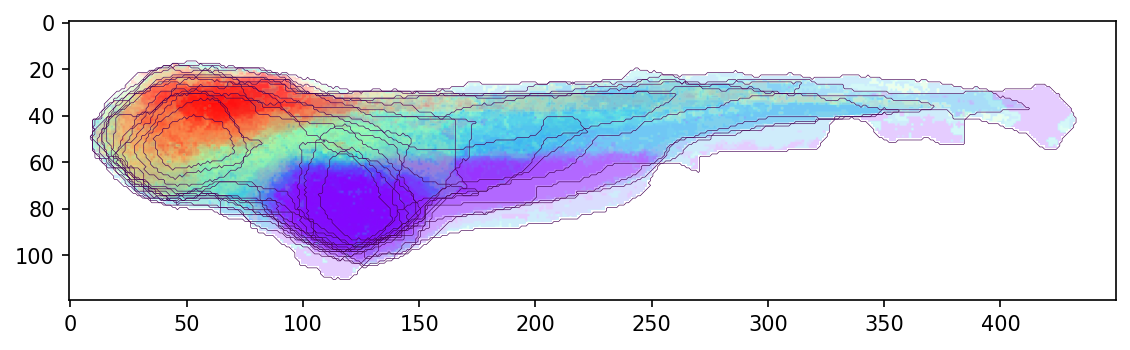

In [2]:
# load the 4cluster images
import os
PATH_IMAGES = np.array([os.path.join('data/anatomical_clusters_global/', x) for x in os.listdir('data/anatomical_clusters_global/')])

# sort the stuff
ix_sort = np.argsort([float(x.split('/')[-1].split('.')[0]) for x in PATH_IMAGES])
PATH_IMAGES = PATH_IMAGES[ix_sort]

# load the images


S = len(images)
S_ix = [int(x.split('/')[-1].split('.')[0]) for x in PATH_IMAGES]

dict_shift = {
    0:[0,-40],
    1:[-6,-26],
    2:[-12,-21],
    3:[-10,-21],
    4:[10,-10],
    5:[0,-10],
    6:[-8,-8],
    7:[-5,-8],
    8:[-37,-5],
    9:[-10,-22],
    10:[-55,-26],
    11:[-48,-25],
    12:[-20,-20],
    13:[0,-10],
    14:[-5,-7],
    15:[-17,-23],
    16:[10,-10],
    17:[-15,-30],
    18:[30,20],
}

dict_rotate = {
    0:-38,
    1:-30,#done
    2:-15,#done
    3:-22,#done
    4:-12,#done
    5:-10,#done
    6:0,#done
    7:-2,#done
    8:5, # done
    9:0, # done
    10:6,# done
    11:6,# done
    12:0, #done
    13:0, # done
    14:-8, # done
    15:-20,# done
    16:-7,#done
    17:-28,#done
    18:0,#done
}

fig = plt.figure(None,(9,5), dpi=150)

images_transformed = []
for s in range(S):
    image_transform = images[s]
    image_transform = rotate(image_transform, dict_rotate[S_ix[s]], order=0, cval=np.nan)
    image_transform = shift(image_transform, dict_shift[S_ix[s]], order=0, cval=np.nan)
    image_transform = image_transform[:120][:,:450]
#     if s >= 0:
#         plt.imshow(image_transform, cmap='rainbow', alpha=0.2)
#         contour = image_transform > 0
#         plt.contour(contour.astype(float), levels=[0.5], linewidths=0.3)
#     if s == 17: break


    plt.imshow(image_transform, cmap='rainbow', alpha=0.2)
    contour = image_transform > 0
    plt.contour(contour.astype(float), levels=[0.5], linewidths=0.3)
    images_transformed.append(image_transform)
    
    
plt.show()

In [3]:
images_transformed = np.array(images_transformed)

In [4]:
# np.save('../ZebraMSI/data/72hClusters.npy', images_transformed)

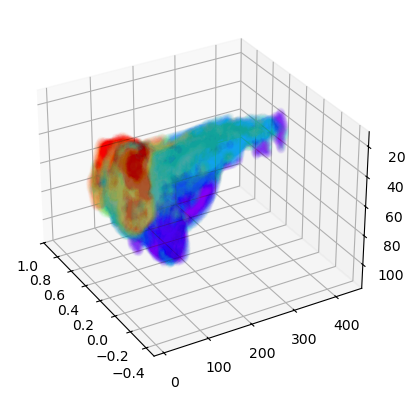

In [5]:
images_transformed = np.array(images_transformed)
images_transformed = np.nan_to_num(images_transformed)
# %matplotlib qt

x,y,z =images_transformed.nonzero() #gets non zero values from stacked

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x/25,z, y, cmap='rainbow',alpha=0.01, c=images_transformed.flatten()[images_transformed.flatten() > 0])

ax.set_xlim([-0.5,1])

ax.view_init(elev=-150., azim=30)
plt.show()

In [6]:
images_total_embryo = images_transformed.astype(bool).astype(float)
# vertices, triangles = mcubes.marching_cubes(binary_sphere, 0.5)

vol =  images_total_embryo
vol = binary_closing(vol, iterations=2)
vol = binary_dilation(vol, structure=np.ones((1,1,20)))
vol = binary_closing(vol, iterations=1)
# symmetrize
# vol =(vol + np.fliplr(vol)).astype(float).m

smoothed_total_embryo = mcubes.smooth(vol)

vertices_total_embryo, triangles_total_embryo = mcubes.marching_cubes(smoothed_total_embryo, 0.5)
vertices_total_embryo, triangles_total_embryo = vertices_total_embryo[:,[2,0,1]], triangles_total_embryo[:,[2,0,1]]
vertices_total_embryo[:,1] = vertices_total_embryo[:,1] * 6 - 15.
vertices_total_embryo[:,0] = vertices_total_embryo[:,0] + 5.

In [7]:
# surface = {}
# surface['vertices'] = vertices_total_embryo
# surface['triangles'] = triangles_total_embryo
# np.save('mesh_72.npy',surface)

In [6]:

vol.shape, smoothed_total_embryo.shape

((15, 120, 450), (15, 120, 450))

In [8]:
vol_gaussian = gaussian_filter(vol.astype(float), 1) > 0.4

In [7]:
# save the volume

np.save('/Users/schede/Desktop/ZebraMSI/data/72h_mask.npy', vol_gaussian.astype(np.int8))

In [9]:
np.sum(vol_gaussian.astype(np.int8))

140688

In [79]:
hollow_object = []
for i in range(vol_gaussian.shape[0]):
    vol_gaussian = vol_gaussian.astype(int)# Erode the binary image
    eroded_image = binary_erosion(vol_gaussian[i])
    
    # Border is the difference between the original and the eroded image
    border = vol_gaussian[i] - eroded_image

    hollow_object.append(border)

In [82]:
hollow_object = np.array(hollow_object)

In [83]:
np.save('/Users/schede/Desktop/ZebraMSI/data/72h_mask_hollow.npy', hollow_object.astype(np.int8))

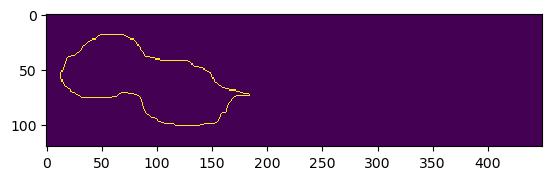

In [85]:
plt.imshow(hollow_object[3], interpolation='none')

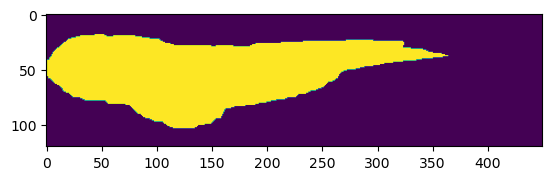

In [69]:
plt.imshow(vol_gaussian[8])

# get molecule

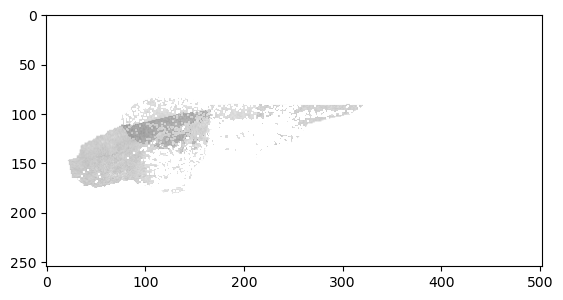

In [12]:
# load the 4cluster images
MOLECULE_SELECT = os.listdir('data/molecule_for_3d_vis/')[2] # 10
# MOLECULE_SELECT = os.listdir('data/arrays/')[70] # 10

PATH_IMAGES = []
for x in os.listdir(f'data/molecule_for_3d_vis/{MOLECULE_SELECT}'):
    tmp = os.path.join(f'data/molecule_for_3d_vis/{MOLECULE_SELECT}', x)
    if float(tmp.split('/')[-1].split('.')[0]) < 2:
        continue
    elif float(tmp.split('/')[-1].split('.')[0]) > 17:
        continue
    PATH_IMAGES.append(tmp)
PATH_IMAGES = np.array(PATH_IMAGES)
# PATH_IMAGES = np.array([os.path.join(f'data/molecule_for_3d_vis/{MOLECULE_SELECT}',
#                                      x) for x in os.listdir(f'data/molecule_for_3d_vis/{MOLECULE_SELECT}')])

# sort the stuff
ix_sort = np.argsort([float(x.split('/')[-1].split('.')[0]) for x in PATH_IMAGES])
PATH_IMAGES = PATH_IMAGES[ix_sort]

# load the images
images = [np.load(x) for x in PATH_IMAGES]

S = len(images)
S_ix = [int(x.split('/')[-1].split('.')[0]) for x in PATH_IMAGES]

plt.imshow(shift(images[10], [40,40], order=0,cval=np.nan), cmap='Greys', alpha=0.3)
plt.imshow(rotate(images[12], 13, order=0, cval=np.nan), cmap='Greys', alpha=0.3)

plt.show()

In [13]:
MOLECULE_SELECT

'755.539'

In [ ]:
dict_shift = {
    0:[0,-40],
    1:[-6,-26],
    2:[-12,-21],
    3:[-10,-21],
    4:[10,-10],
    5:[0,-10],
    6:[-8,-8],
    7:[-5,-8],
    8:[-37,-5],
    9:[-10,-22],
    10:[-55,-26],
    11:[-48,-25],
    12:[-20,-20],
    13:[0,-10],
    14:[-5,-7],
    15:[-17,-23],
    16:[10,-10],
    17:[-15,-30],
    18:[30,20],
}

dict_rotate = {
    0:-38,
    1:-30,#done
    2:-15,#done
    3:-22,#done
    4:-12,#done
    5:-10,#done
    6:0,#done
    7:-2,#done
    8:5, # done
    9:0, # done
    10:6,# done
    11:6,# done
    12:0, #done
    13:0, # done
    14:-8, # done
    15:-20,# done
    16:-7,#done
    17:-28,#done
    18:0,#done
}

fig = plt.figure(None,(9,5), dpi=150)

images_transformed = []
for s in range(S):
    image_transform = images[s]
    image_transform = rotate(image_transform, dict_rotate[S_ix[s]], order=0, cval=np.nan)
    image_transform = shift(image_transform, dict_shift[S_ix[s]], order=0, cval=np.nan)
    image_transform = image_transform[:120][:,:450]
#     if s >= 0:
#         plt.imshow(image_transform, cmap='rainbow', alpha=0.2)
#         contour = image_transform > 0
#         plt.contour(contour.astype(float), levels=[0.5], linewidths=0.3)
#     if s == 17: break


    plt.imshow(image_transform, cmap='Greys', alpha=0.2)
    contour = image_transform > 0
    plt.contour(contour.astype(float), levels=[0.5], linewidths=0.3)
    images_transformed.append(image_transform)
    
    
plt.show()


small_num = np.nanmin(np.exp(np.array(images_transformed).flatten()))

images_transformed = np.array(images_transformed)
images_transformed[images_transformed >= -0.4] = np.nan
images_transformed = np.exp(np.array(images_transformed))
images_transformed = np.nan_to_num(images_transformed) - small_num
# images_transformed = np.clip(images_transformed, 0, np.percentile(images_transformed, 99))
# images_transformed = gaussian_filter(images_transformed, 1.)
images_transformed[images_transformed <= 0.] = 0.
vol_molecule = images_transformed / images_transformed.max()
vol_molecule = np.moveaxis(vol_molecule, 2, 0)
images_transformed = images_transformed / images_transformed.max()


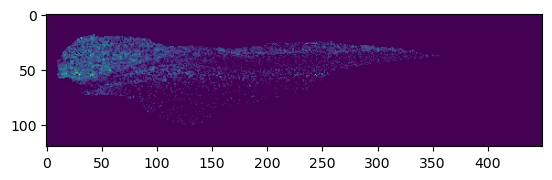

In [769]:
plt.imshow(images_transformed[8], vmax=0.8)

In [770]:
## save object in website data
path_save = f'/Users/schede/Desktop/ZebraMSI/data/forDownload/72/{MOLECULE_SELECT.replace(".", "_")}.npy'

In [765]:
np.save(path_save, images_transformed)

# run in napari

In [431]:
# retrieve the color by checking what molecule it might belong to
lcms = pd.read_csv('data/zebrafish_lcms_matrix_standard_73yvgl_withcounterions.txt', index_col=0)

THRESH = 0.015
if np.min(np.abs(float(MOLECULE_SELECT) - lcms['m/z'].values)) < THRESH:
    ix_select = np.argmin(np.abs(float(MOLECULE_SELECT) - lcms['m/z'].values))
    selected_class = lcms.iloc[ix_select].Class
else:
    selected_class = 'none'

In [432]:
if selected_class == 'none':
    color = 'gray'
elif selected_class == 'GP01_PC':
    color = 'bop orange'
elif selected_class == 'GP02_PE':
    color = 'bop blue'
elif selected_class == 'GP01_LysoPC':
    color = 'yellow'
elif selected_class == 'GL02_DAG':
    color = 'red'
elif selected_class == 'SP03_PCCer':
    color = 'green'
elif selected_class == 'GP03_PS':
    color = 'cyan'
else:
    colors = np.linspace(
    start=[0, 0, 0, 0],
    stop=[0.6, 0.9, 0.6, 1],
    num=10,
    endpoint=True)
    color = {
    'colors': colors,
    'name': 'white_to_blue',
    'interpolation': 'linear'}

print(color)

gray


In [433]:
%gui qt
import napari


In [434]:

viewer = napari.Viewer(ndisplay=3)
# add a volume


# get the current state
state = viewer.window.qt_viewer.view.camera.get_state()
# change the state to position 1
state['_quaternion'].w =-0.291
state['_quaternion'].x = -0.625
state['_quaternion'].y  = 0.64
state['_quaternion'].z =  0.339
state['scale_factor'] = 400
state['center'] = (59.5, 31.5, 224.5)
viewer.window.qt_viewer.view.camera.set_state(state)




values = np.linspace(0, 1, len(vertices_total_embryo))
surface = (vertices_total_embryo, triangles_total_embryo, values)
contour_layer = viewer.add_surface(surface, blending='translucent_no_depth', opacity=0.2,
                                   gamma=0.2, 
                                  contrast_limits=[0,0.3],
                                  shading='none') 

volume_layer = viewer.add_image(
    data=vol_molecule, name='volume',scale=[1,3.5,1], gamma=0.65, contrast_limits=[0.2,1.],
    blending='additive',interpolation='nearest',colormap=color
)

viewer.window.qt_viewer.view.camera.set_state(state)

movie = Movie(myviewer=viewer)


<ipython-input-434-356d42396132>:6: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  state = viewer.window.qt_viewer.view.camera.get_state()
<ipython-input-434-356d42396132>:14: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  viewer.window.qt_viewer.view.camera.set_state(state)
<ipython-input-434-356d42396132>:31: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use

In [393]:
# state 2:
state['_quaternion'].w =-0.251
state['_quaternion'].x = 0.706
state['_quaternion'].y  = -0.64
state['_quaternion'].z = 0.17
viewer.window.qt_viewer.view.camera.set_state(state)

# state 3
state['_quaternion'].w =-0.512
state['_quaternion'].x = 0.559
state['_quaternion'].y  = -0.463
state['_quaternion'].z =0.458
viewer.window.qt_viewer.view.camera.set_state(state)

# state 4

state['_quaternion'].w =0.671
state['_quaternion'].x = -0.0883
state['_quaternion'].y  = 0.0254
state['_quaternion'].z =-0.736
viewer.window.qt_viewer.view.camera.set_state(state)

# state 5

state['_quaternion'].w =-0.483
state['_quaternion'].x =  -0.485
state['_quaternion'].y  =0.487
state['_quaternion'].z = 0.543
viewer.window.qt_viewer.view.camera.set_state(state)

# state 6
state['_quaternion'].w =-0.291
state['_quaternion'].x = -0.625
state['_quaternion'].y  = 0.64
state['_quaternion'].z =  0.339
viewer.window.qt_viewer.view.camera.set_state(state)

<ipython-input-393-f1675e91a0e7>:6: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  viewer.window.qt_viewer.view.camera.set_state(state)
<ipython-input-393-f1675e91a0e7>:13: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  viewer.window.qt_viewer.view.camera.set_state(state)
<ipython-input-393-f1675e91a0e7>:21: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use ca

In [442]:
movie.make_gif(f'gifs_molecules/{MOLECULE_SELECT}.gif')




/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:269: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  new_state = copy.deepcopy(self.myviewer.window.qt_viewer.view.camera.get_state())
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:283: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.myviewer.window.qt_viewer.view.camera.set_state(new_state)
/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/naparimovie/naparimovie.py:284: FutureWarn